In [236]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize
from sklearn import tree
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [237]:
second_sales = "EU_Sales"

# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", second_sales]
data = data.filter(items=columns_used_for_clustering)

# compute stats for each column
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})

# standardization
standardize(data, columns_used_for_clustering, columns_stats)

# outlier detection
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

# drop outliers from the dataset
data = drop_outliers_from_dataset(data, outliers)

# de-standardization
de_standardize(data, columns_used_for_clustering, columns_stats)

### Classification - NA_Sales prediction using other sales and Critic_Score

In [238]:
# create artificial clusters
data["cluster"] = 0
data.loc[data["NA_Sales"] > 0.2, "cluster"] = 1
data.loc[data["NA_Sales"] > 0.7, "cluster"] = 2

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

Number of entries in each cluster:
0    1232
1    1051
2     412
Name: cluster, dtype: int64


### Display clusters and information about them

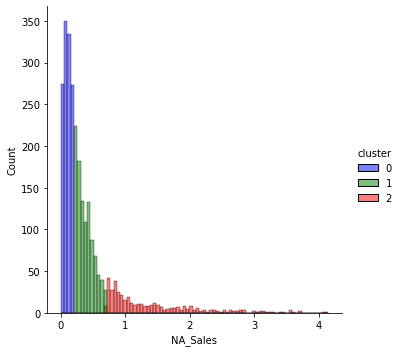

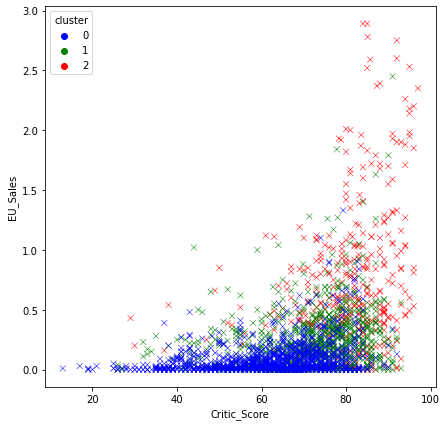

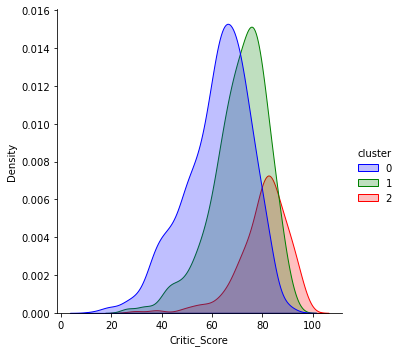

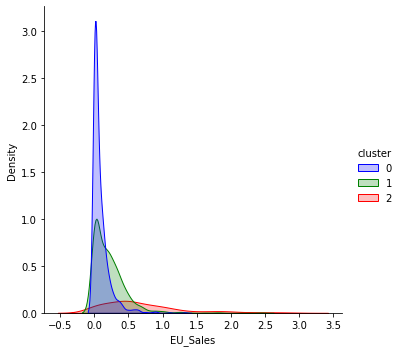

In [239]:
palette = ["blue", "green", "red"]

sns.displot(data, x="NA_Sales", hue="cluster", palette=palette)
plt.show()

sns.scatterplot(data=data, x="Critic_Score", y=second_sales, hue="cluster", palette=palette, marker='x')
plt.show()

sns.displot(data, x="Critic_Score", hue="cluster", kind="kde", palette=palette, fill=True)
sns.displot(data, x=second_sales, hue="cluster", kind="kde", palette=palette, fill=True)


### Drop column with NA_Sales - it should not be used in the classification, standardize data

In [240]:
data = data.drop(["NA_Sales"], axis=1)
standardize(data, [second_sales, "Critic_Score"], columns_stats)

### Perform classification using KNN, with different numbers of neighbours

K = 1 - correct: 0.5573283858998145
K = 2 - correct: 0.5651205936920223
K = 3 - correct: 0.5673469387755102
K = 4 - correct: 0.6014842300556587
K = 5 - correct: 0.5884972170686457
K = 6 - correct: 0.6003710575139146
K = 7 - correct: 0.6055658627087198
K = 8 - correct: 0.6152133580705009
K = 9 - correct: 0.6181818181818182
K = 10 - correct: 0.6144712430426716
K = 11 - correct: 0.6233766233766234
K = 12 - correct: 0.6115027829313544
K = 13 - correct: 0.6256029684601113
K = 14 - correct: 0.6192949907235622
K = 15 - correct: 0.6181818181818182
K = 16 - correct: 0.6267161410018552
K = 17 - correct: 0.6256029684601113
K = 18 - correct: 0.6293135435992578
K = 19 - correct: 0.6230055658627087
K = 20 - correct: 0.624860853432282
K = 21 - correct: 0.6226345083487941
K = 22 - correct: 0.6181818181818182
K = 23 - correct: 0.6226345083487941
K = 24 - correct: 0.6256029684601113
K = 25 - correct: 0.624860853432282
K = 26 - correct: 0.625974025974026
K = 27 - correct: 0.6263450834879406
K = 28 - corr

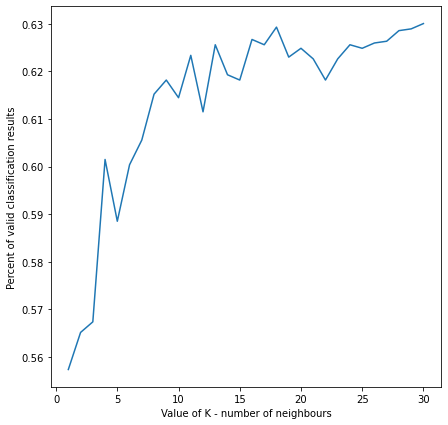

In [241]:
qualities = []
for number_of_neighbours in range(1, 31):
    classification_quality, _ = k_neighbours_leave_one_out(data, "cluster", number_of_neighbours)
    print("K = {} - correct: {}".format(number_of_neighbours, classification_quality))
    qualities.append(classification_quality)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), qualities)
plt.show()

### Perform classification using other methods: decision tree

In [242]:
classification_quality, _ = decision_tree_leave_one_out(data, "cluster")
print("Accuracy for leave one out - decision tree: {}".format(classification_quality))

Accuracy for leave one out - decision tree: 0.5825602968460112


### Split the dataset into training and testing parts for further studies

In [243]:
X = data[["Critic_Score", second_sales]].to_numpy()
Y = data["cluster"].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

training_data = pd.DataFrame(np.concatenate((X_train, np.expand_dims(Y_train, axis=1)), axis=1),
                             columns=["Critic_Score", second_sales, "cluster"])
training_data["cluster"] = training_data["cluster"].astype(int)

testing_data = pd.DataFrame(np.concatenate((X_test, np.expand_dims(Y_test, axis=1)), axis=1),
                            columns=["Critic_Score", second_sales, "cluster"])
testing_data["cluster"] = testing_data["cluster"].astype(int)

### Perform classification using KNN, for different numbers of neighbours

K = 1 - test data score: 0.5324675324675324, training data score: 0.8668831168831169
K = 2 - test data score: 0.5602968460111317, training data score: 0.7490723562152134
K = 3 - test data score: 0.5435992578849722, training data score: 0.7527829313543599
K = 4 - test data score: 0.5732838589981447, training data score: 0.7128942486085343
K = 5 - test data score: 0.5528756957328386, training data score: 0.7198515769944341
K = 6 - test data score: 0.5732838589981447, training data score: 0.7105751391465677
K = 7 - test data score: 0.575139146567718, training data score: 0.7082560296846011
K = 8 - test data score: 0.5769944341372912, training data score: 0.6804267161410018
K = 9 - test data score: 0.5899814471243042, training data score: 0.6859925788497218
K = 10 - test data score: 0.5899814471243042, training data score: 0.6753246753246753
K = 11 - test data score: 0.5936920222634509, training data score: 0.674860853432282
K = 12 - test data score: 0.6048237476808905, training data score

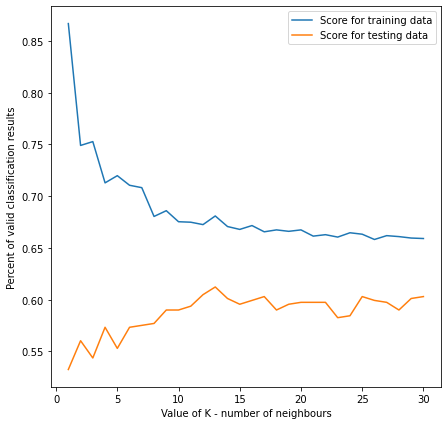

In [244]:
accuracy_test = []
accuracy_train = []
for number_of_neighbours in range(1, 31):
    classifier = KNeighborsClassifier(n_neighbors=number_of_neighbours)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("K = {} - test data score: {}, training data score: {}".format(number_of_neighbours, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Value of K - number of neighbours")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 31), accuracy_train, label="Score for training data")
plt.plot(range(1, 31), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using KNN, for K = 15

Accuracy for testing data: 0.5955473098330241
Accuracy for training data: 0.6679035250463822


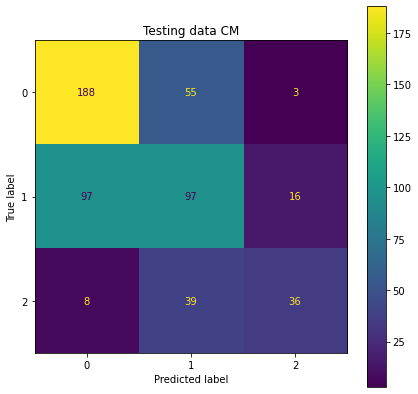

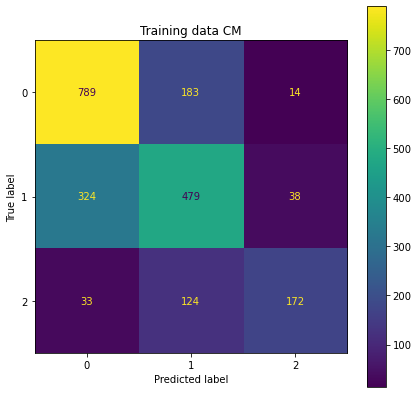

In [245]:
classifier = KNeighborsClassifier(n_neighbors=15)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()

### Perform classification using decision tree for different max depths

Max depth = 1 - test data score: 0.5380333951762524, training data score: 0.5667903525046383
Max depth = 2 - test data score: 0.5769944341372912, training data score: 0.6484230055658627
Max depth = 3 - test data score: 0.5769944341372912, training data score: 0.6484230055658627
Max depth = 4 - test data score: 0.5862708719851577, training data score: 0.6632653061224489
Max depth = 5 - test data score: 0.5862708719851577, training data score: 0.6706864564007421
Max depth = 6 - test data score: 0.5862708719851577, training data score: 0.686456400742115
Max depth = 7 - test data score: 0.601113172541744, training data score: 0.6985157699443414
Max depth = 8 - test data score: 0.5788497217068646, training data score: 0.7272727272727273
Max depth = 9 - test data score: 0.5714285714285714, training data score: 0.75139146567718
Max depth = 10 - test data score: 0.5788497217068646, training data score: 0.775974025974026


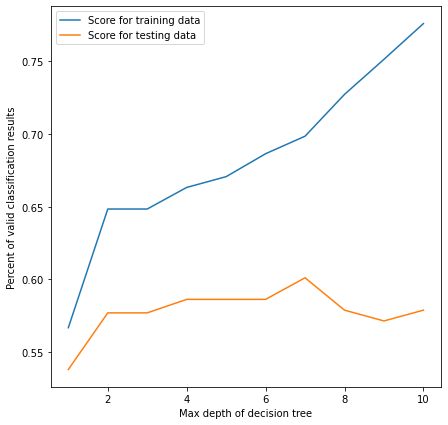

In [246]:
accuracy_test = []
accuracy_train = []
for max_depth in range(1, 11):
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth)\
        .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
    train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])

    print("Max depth = {} - test data score: {}, training data score: {}".format(max_depth, test, train))
    accuracy_test.append(test)
    accuracy_train.append(train)

plt.figure()
plt.xlabel("Max depth of decision tree")
plt.ylabel("Percent of valid classification results")
plt.plot(range(1, 11), accuracy_train, label="Score for training data")
plt.plot(range(1, 11), accuracy_test, label="Score for testing data")
plt.legend()
plt.show()

### Perform classification using decision tree for max depth = 3

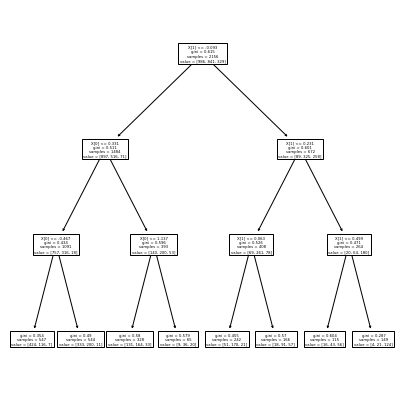

Accuracy for testing data: 0.5769944341372912
Accuracy for training data: 0.6484230055658627


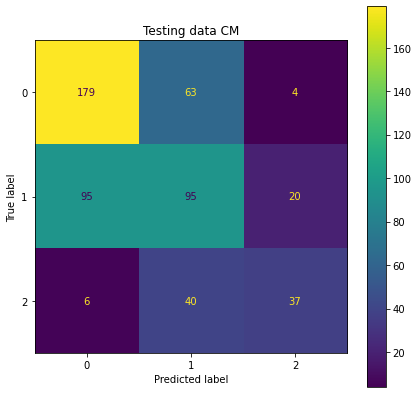

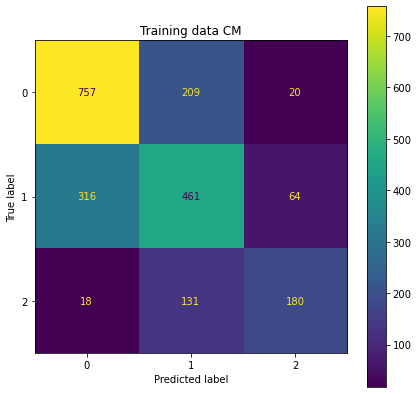

In [247]:
# Note: reducing the depth of this tree has no significant impact on the testing score - only on the training
# score (and even there the impact is not that big) - this is because the tree is "over-fitting"
classifier = tree.DecisionTreeClassifier(max_depth=3)\
    .fit(training_data[["Critic_Score", second_sales]], training_data["cluster"])
tree.plot_tree(classifier)
plt.show()

accuracy_test = classifier.score(testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
print("Accuracy for testing data: {}".format(accuracy_test))

accuracy_train = classifier.score(training_data[["Critic_Score", second_sales]], training_data["cluster"])
print("Accuracy for training data: {}".format(accuracy_train))

plot_confusion_matrix(classifier, testing_data[["Critic_Score", second_sales]], testing_data["cluster"])
plt.title("Testing data CM")
plt.show()

plot_confusion_matrix(classifier, training_data[["Critic_Score", second_sales]], training_data["cluster"])
plt.title("Training data CM")
plt.show()
